# 一. 重返泰坦尼克号

本次数据分析的对象是泰坦尼克号数据，包括泰坦尼克号上2224名乘客和船员中891名的人口学数据和乘客基本信息，由Kaggle网站提供。下表中展示了前5条数据的基本情况：

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

In [129]:
# format_percent formats a decimal fraction into percentage string.
def format_percent(frac):
    return str(round(frac, 4) * 100) + '%'

# render a bar plot for group-by data
def bar_group_by(group_by, column, xlabel=None):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    group_by[column].count().plot(kind='bar')
    plt.ylabel('number of passengers')
    if xlabel is not None:
        plt.xlabel(xlabel)

    plt.subplot(1, 2, 2)
    group_by[column].mean().plot(kind='bar')
    plt.ylabel('survived rate')
    if xlabel is not None:
        plt.xlabel(xlabel)

# render a pie plot for group-by data
def pie_group_by(group_by, column, ylabel, labels):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    group_by[column].count().plot(kind='pie', autopct='%.2f%%', labels=labels)
    plt.ylabel('number of passengers')

    plt.subplot(1, 2, 2)
    group_by[column].mean().plot(kind='pie', autopct='%.2f%%', labels=labels)
    plt.ylabel(ylabel)

In [130]:
# take a look at data
titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


每个乘客包含12项基本信息：

1. PassengerId：乘客唯一ID
2. Survived：是否生还，0表示遇难，1表示生还
3. Pclass：客舱等级，1表示头等舱，2表示二等舱，3表示下等舱
4. Name：乘客姓名
5. Sex：性别，男（male）或女（female）
6. Age：年龄
7. SibSp：同在船上的兄弟姐妹/配偶数量
8. Parch：同在船上的双亲/子女数量
9. Ticket：票号
10. Fare：船票票价
11. Cabin：客舱号
12. Embarked：登船港口，C = Cherbourg, Q = Queenstown, S = Southampton

从表格中展示的基本情况可以看出，有一部分乘客的客舱号数据已经遗失（NaN）。另外根据Kaggle上的说明，乘客的年龄为浮点数，小于1岁的乘客年龄为分数，如果不知道确切年龄，那么乘客的年龄格式为xx.5。sibsp数据忽略了未婚夫/未婚妻关系，parch数据包括了继子/继女关系，一些儿童乘客是跟保姆一起坐船的，对他们而言parch=0。

# 二. 感兴趣的问题

对于泰坦尼克号数据，我所感兴趣的问题是：

1. 乘客汇总统计信息和总体生还情况
2. 乘客的年龄分布大致情况，最大年龄和最小年龄的生还情况是怎样的？
3. 不同年龄段乘客的生还率是怎样的？
4. 乘客在船票上的花费是怎样的？
5. 不同客舱等级乘客的生还率和平均船票花费分别是怎样的？
6. 不同性别乘客的生还率和平均船票花费分别是怎样的？
7. 带着兄弟姐妹/配偶一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？
8. 带着双亲/子女一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？
9. 0-16岁儿童乘客的生还情况如何？其中有多少是没有跟着父母一起登船的？他们的生还情况如何？

# 三. 对数据进行整理

In [131]:
# check whether number of rows and unique number of passengers match
num_of_rows = len(titanic_df['PassengerId'])
num_of_uniq = len(titanic_df['PassengerId'].unique())
print('# of rows: {}; # of unique passengers: {}\n'.format(num_of_rows, num_of_uniq))

# check if there exists missing data.
print('investigate the missing data of each columns:')
missing = titanic_df.isnull().sum()
ratio = calculate_ratio(titanic_df.isnull().sum(), float(len(titanic_df)))
round_ratio = ratio.apply(lambda x: format_percent(x))
print(pd.concat([missing.rename('missing'), round_ratio.rename('percentage(%)')], axis='columns'))

# are Pclass, Sex and Embarked data avaiable?
print('\ninvestigating Pclass')
print(titanic_df.groupby('Pclass').groups.keys())

print('\ninvestigating Sex')
print(titanic_df.groupby('Sex').groups.keys())

print('\ninvestigating Embarked')
print(titanic_df.groupby('Embarked').groups.keys())

# of rows: 891; # of unique passengers: 891

investigate the missing data of each columns:
             missing percentage(%)
PassengerId        0          0.0%
Survived           0          0.0%
Pclass             0          0.0%
Name               0          0.0%
Sex                0          0.0%
Age              177        19.87%
SibSp              0          0.0%
Parch              0          0.0%
Ticket             0          0.0%
Fare               0          0.0%
Cabin            687         77.1%
Embarked           2         0.22%

investigating Pclass
[1, 2, 3]

investigating Sex
['male', 'female']

investigating Embarked
['Q', 'C', 'S']


从以上对数据的初步调查可以看出，数据集的行数与乘客的数量相等，也就是说**不存在重复的数据**。然而年龄、客舱和登船港口数据存在缺失。有177名乘客的年龄数据缺失，占比19.87%，那么**在进行针对年龄的数据分析时必须把这部分数据筛除，否则势必影响结论的可靠性**；有687项数据缺失了客舱信息，占比77.1%，是数据缺失的重灾区，好在这对后面要进行的数据分析不存在影响：我们只需要知道客舱的等级就好，不需要知道具体客舱号，客舱等级数据不存在缺失。登陆港口只有两项数据是缺失的，占比不大，因此对结论的影响较小。最后，检查了一下客舱等级，性别和登陆港口数据，因为这些数据是有限取值范围的枚举值，检查下有没有错误数据，**结论是没有**。

In [132]:
# filter out NaN 'Age' data, drop 'Cabin' too.
titanic_df_age = titanic_df[pd.notnull(titanic_df['Age'])].drop('Cabin', axis=1)
# filter out NaN 'Embarked' data, drop 'Cabin' too.
titanic_df_embark = titanic_df[pd.notnull(titanic_df['Embarked'])].drop('Cabin', axis=1)
# check the filtered data.
print('valid age {}, valid embark {}'.format(len(titanic_df_age), len(titanic_df_embark)))
display(titanic_df_age.head())
display(titanic_df_embark.head())

valid age 714, valid embark 889


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


为方便后面的分析工作，我们对数据进行了清洗。对于后面要进行的有关乘客年龄的数据分析，我们将缺失数据滤除，对登陆港口也做同样处理，由于只需要知道客舱等级而不再需要客舱号，因此顺便将客舱号这列删除。最后打印了一下清洗后的数据进行观察，跟预期的一致，没有问题。

# 四. 数据分析

## 1. 乘客汇总统计信息和总体生还情况

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


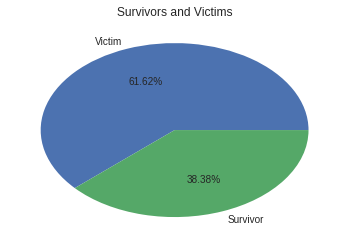

In [133]:
display(titanic_df.describe())
titanic_df.groupby('Survived')['PassengerId'].count().plot(kind='pie', autopct='%.2f%%', labels=['Victim','Survivor'])
plt.title('Survivors and Victims')
plt.ylabel('')

891名乘客平均年龄约29.70周岁，标准差为14.53，表明年龄分布较为分散，最大年龄乘客80岁，最小的不足1岁；有乘客最多带了8位家属（兄弟姐妹/配偶）登船，还有的乘客最多带了6位直系血亲（父母/子女）登船；这些乘客购买船票平均花费了约32.20货币单位，标准差49.69，表明不同乘客的船票开销差异较大。这891人的生还率约为38.38%，不到一半的人在这次灾难中幸存下来。

## 2. 乘客的年龄分布大致情况，最大年龄和最小年龄的生还情况是怎样的？

Details of number of passengers per age range


Age
(0, 10]      64
(10, 20]    115
(20, 30]    230
(30, 40]    155
(40, 50]     86
(50, 60]     42
(60, 70]     17
(70, 80]      5
Name: PassengerId, dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,S


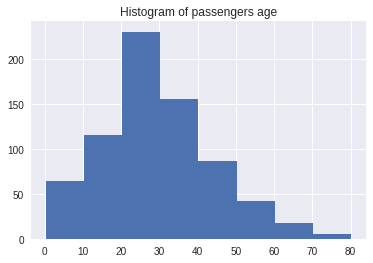

In [134]:
# get categories by Age ranges.
cat_age = pd.cut(titanic_df_age["Age"], np.arange(0, 90, 10))
print('Details of number of passengers per age range')
display(titanic_df_age.groupby(cat_age).count()['PassengerId'])

# ages are between 0 and 80.
plt.title('Histogram of passengers age')
titanic_df_age['Age'].hist(bins=8)

display(titanic_df_age[titanic_df_age.Age == 80])
display(titanic_df_age[titanic_df_age.Age < 1])

由于乘客最大年龄为80岁，最小不足1岁，所以从乘客年龄范围统计数据和直方图的角度观察，发现20岁以上30岁以下的乘客数量最多，达230人，其次是30岁以上40岁以下，有155人。然后我们调查了最大年龄为80岁的乘客和所有不足1岁乘客的生还情况，发现他们都生还了，真是幸运！

## 3. 不同年龄段乘客的生还情况是怎样的？

there are 714 passengers with age, 40.62% are survived


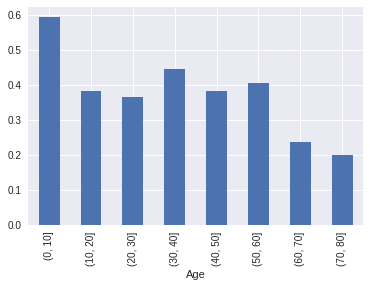

In [135]:
# investigate data with available 'Age'
survived_rate_age = titanic_df_age['Survived'].mean()
print('there are {} passengers with age, {} are survived'.
      format(len(titanic_df_age), format_percent(survived_rate_age)))

# investigate data group by age ranges
group_by_age = titanic_df_age.groupby(cat_age)['Survived'].mean().plot(kind='bar')

以上是对具有有效年龄数据的乘客进行的统计分析。观察到这部分乘客总体生还率约为40.62%。因为最大年龄为80岁，因此这里我们对年龄进行了从0到80岁的分段分析，发现10岁以下的乘客生还率最高，其次是30岁以上40岁以下的。超过60岁的乘客生还率相对最低，远远不及其他年龄段乘客。可以看的出来年龄还是能够影响生还率的。在巨大的灾难面前，小孩子的求生能力是肯定不如成年人的，这么高的生还率只能解释为：在救生船资源有限的情况下，成年人把生的机会让给了儿童。

## 4. 乘客在船票上的花费是怎样的？

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


number of passengers who spent fare <= 100: 838


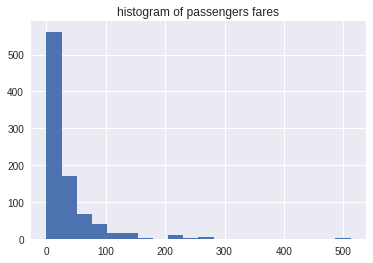

In [137]:
# check the free passengers with no cost
display(titanic_df[titanic_df['Fare'] == 0.0])

ax = titanic_df['Fare'].hist(bins=20)
ax.set_title('histogram of passengers fares')

cat_fare = pd.cut(titanic_df['Fare'], np.arange(0, 550, 20))
print('number of passengers who spent fare <= 100: {}'.
      format(titanic_df[titanic_df['Fare'] <= 100.0]['PassengerId'].count()))

在这891名乘客中，绝大多数乘客（838名）船票花费不足100个货币单位。由于发现还有没花钱免费坐船的乘客，于是对这部分乘客比较好奇，调查了所有没有花钱买船票的乘客，发现他们有几个共同点：1.没有带兄弟姐妹/配偶；2.没有带父母/子女；3.都是男性；4.绝大部分都已遇难，只有1人生还；5.登船地点都是Southampton。查了泰坦尼克号的维基百科，这艘游轮正是**1912年4月10日从英国南安普顿**出发的，因此这些免费乘船的乘客应该都是泰坦尼克号上的船员，他们都非常负责地坚守到了最后，几乎无人生还。

## 5. 不同客舱等级乘客的生还率和平均船票花费分别是怎样的？

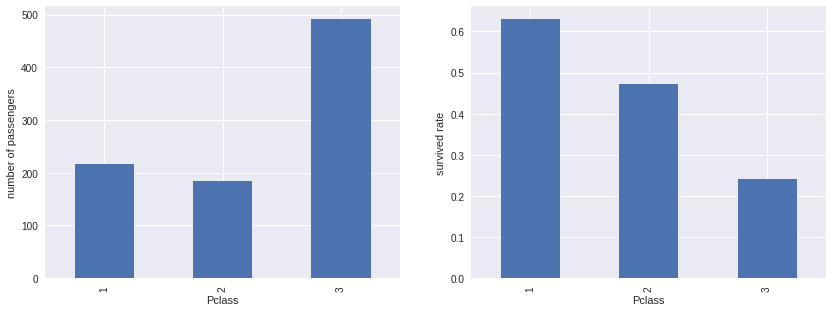

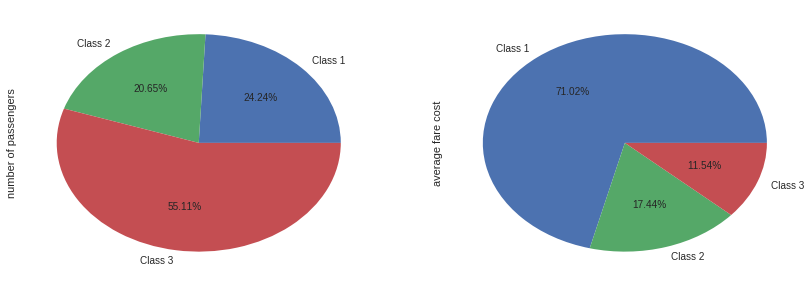

In [138]:
group_by_pclass = titanic_df.groupby('Pclass')
bar_group_by(group_by_pclass, 'Survived')
pie_group_by(group_by_pclass, 'Fare', 'average fare cost', ['Class 1', 'Class 2', 'Class 3'])

从第一组图中可以看出，三等舱乘客数量是最多的，其次是头等舱，二等舱乘客最少。然而头等舱乘客的生还率最高，其次是二等舱乘客，最后是三等舱乘客。这充分说明客舱等级是影响生还率的重要因素。第二组图同样对比了三种客舱人数和平均船票花销，只不过采用了饼图进行对比分析。头等舱乘客的消费能力远在二等舱和三等舱之上，客舱等级越高花的钱越多，那么也可以说，船票开销也是影响生还率的一个因素。一个合理的解释是：头等舱靠近甲板，处于船体的上层；二等舱处于船体中层；三等舱处于船体下层，发生海难时，海水是从船体下部灌入的，因此三等舱乘客逃生难度最大，其次是二等舱，最后是头等舱。

## 6. 不同性别乘客的生还率和平均船票花费分别是怎样的？

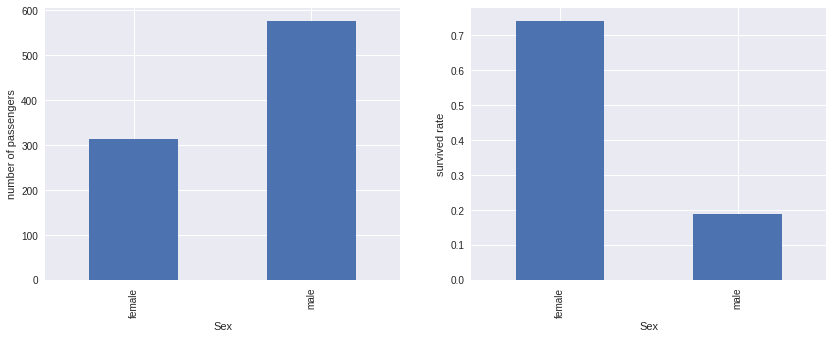

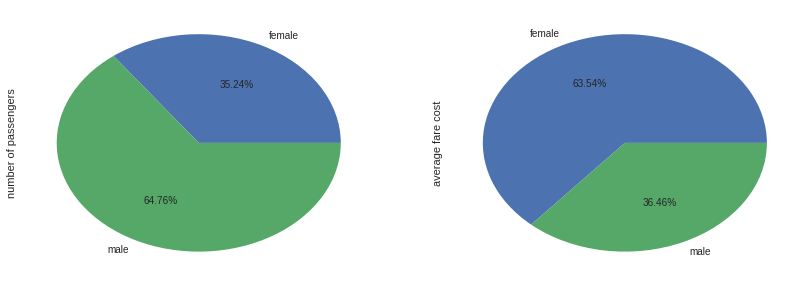

In [139]:
group_by_gender = titanic_df.groupby('Sex')
bar_group_by(group_by_gender, 'Survived')
pie_group_by(group_by_gender, 'Fare', 'average fare cost', ['female', 'male'])

第一组图对比分析了性别与生还率的关系，首先船上的男乘客几乎是女乘客的一倍，然而女乘客的生还率几乎是男乘客的三倍，这说明性别对生还率的影响很大。男人们发扬了真正的绅士风度，在救生资源有限的情况下把生的希望让给了女人和孩子，自己选择葬身鱼腹，这是令人肃然起敬的。第二组饼图对比了两种性别的船票开销，约35.24%的女乘客贡献了约63.54%的消费占比，女性还是更舍得花钱买好的乘坐环境的。

## 7. 带着兄弟姐妹/配偶一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？

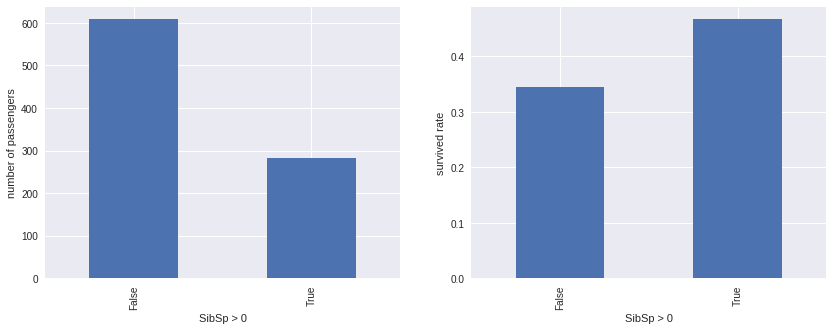

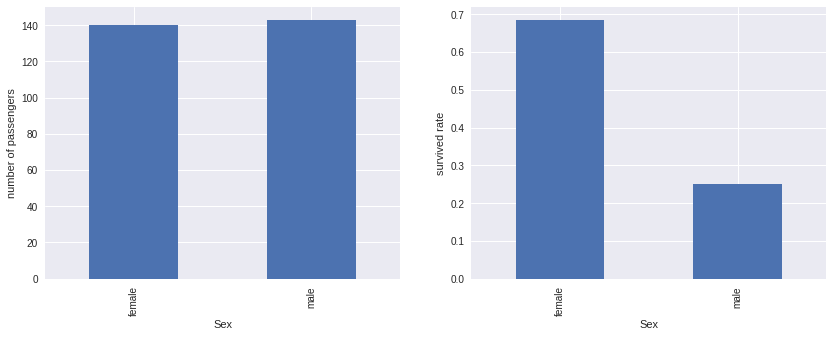

In [140]:
group_by_sibsp = titanic_df.groupby(titanic_df['SibSp'] > 0)
bar_group_by(group_by_sibsp, 'Survived', 'SibSp > 0')
sibsp_group_by_gender = titanic_df[titanic_df['SibSp'] > 0].groupby('Sex')
bar_group_by(sibsp_group_by_gender, 'Survived')

从上面第一组图中可以看到，没有带兄弟姐妹/配偶的乘客要比带了的多一倍，然而前者的生还率却不及后者，一种较为合理的解释是，带了兄弟姐妹/配偶的乘客更容易相互扶持，彼此照顾，因而获救生还的概率要高一些。然而对这部分乘客进一步分析可以发现，虽然带了兄弟姐妹/配偶的乘客在数量上旗鼓相当，但其中女性乘客的生还率仍然远高于男性，性别仍然是一个相当重要的影响因素。

## 8. 带着双亲/子女一同登船的乘客，他们的生还率如何？其中的男性乘客呢？女性乘客呢？

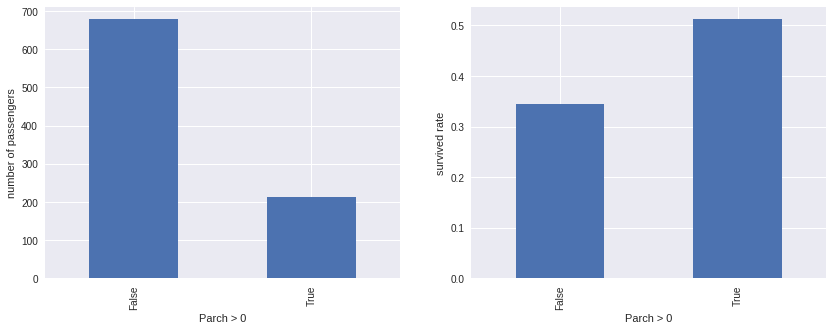

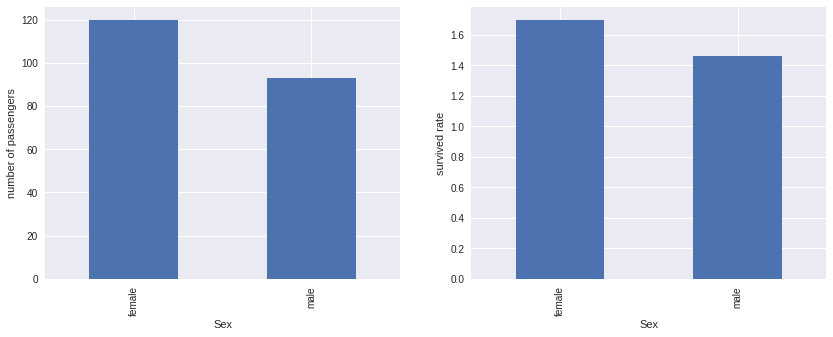

In [141]:
group_by_parch = titanic_df.groupby(titanic_df['Parch'] > 0)
bar_group_by(group_by_parch, 'Survived', 'Parch > 0')

parch_group_by_gender = titanic_df[titanic_df['Parch'] > 0].groupby('Sex')
bar_group_by(parch_group_by_gender, 'Parch')

带着父母/子女一同乘船的乘客在数量上要比不带的少很多，但前者的生还率比后者高。合理的解释仍然是带了父母子女的乘客更容易相互扶持，彼此照顾，因而获救生还的概率要高一些，且其中带着子女的父母，因为需要照顾子女是可以上救生船的，这无疑增加了生还的概率，对这类乘客进一步的分性别分析可以看出，女性的数量要比男性多，某种程度上获救的机会就更大了。

## 9. 0-16岁儿童乘客的生还情况如何，这时性别因素还有影响吗？

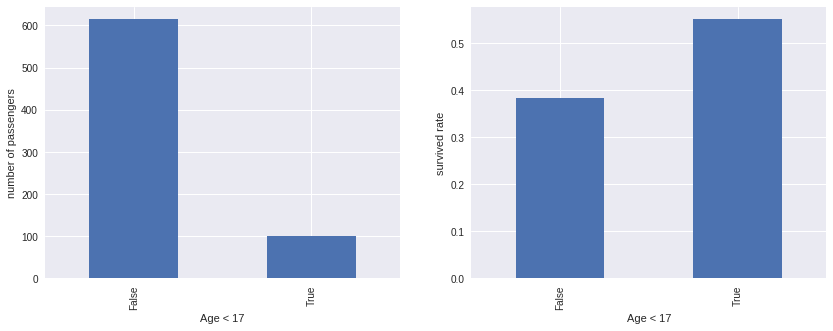

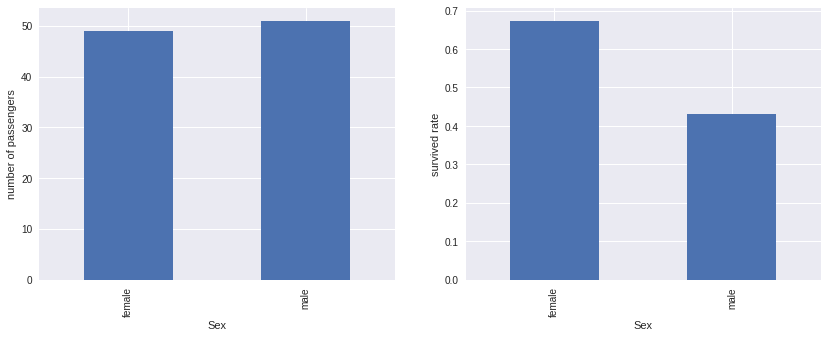

In [142]:
group_by_teenager = titanic_df_age.groupby(titanic_df_age['Age'] < 17)
bar_group_by(group_by_teenager, 'Survived', 'Age < 17')

teenager_group_by_gender = titanic_df_age[titanic_df_age['Age'] < 17].groupby('Sex')
bar_group_by(teenager_group_by_gender, 'Survived')

从第一组图中可以看到，共有约100名儿童乘客，他们的生还率要远远高于17岁以上乘客，从第二组图的进一步分析可以发现，虽然儿童乘客男女比例相当，但性别因素仍然具有相当的影响力，儿童乘客中女性的生还率还是要比男性高！

## 10. 独自一人登船的乘客生还情况如何，性别因素会有影响吗？

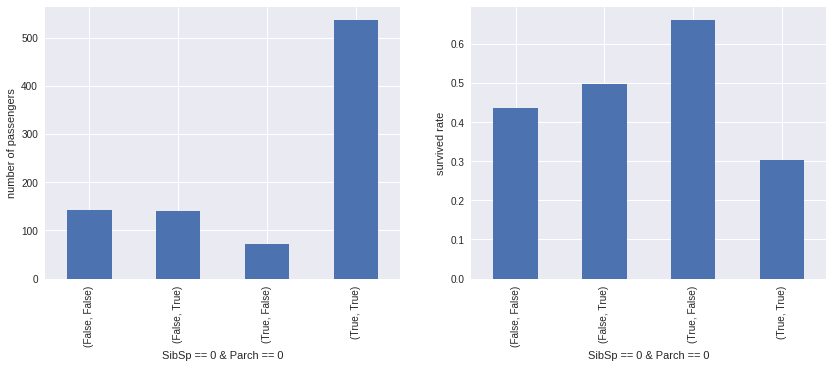

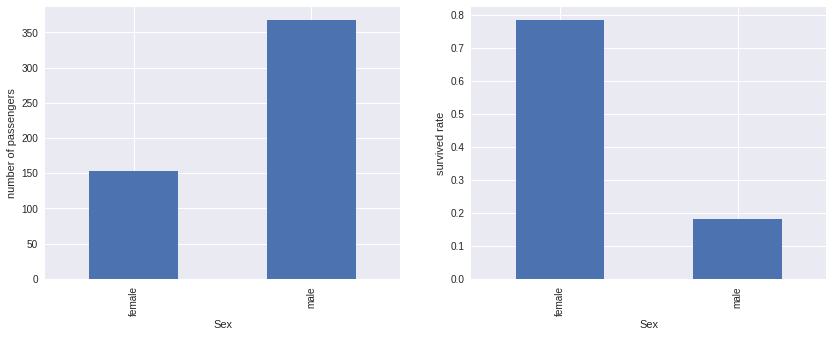

In [143]:
group_by_alone = titanic_df.groupby([titanic_df.SibSp == 0, titanic_df.Parch == 0])
bar_group_by(group_by_alone, 'Survived', 'SibSp == 0 & Parch == 0')

alone_group_by_gender = titanic_df_age.loc(titanic_df.SibSp == 0)[titanic_df.Parch == 0].groupby('Sex')
bar_group_by(alone_group_by_gender, 'Survived')

独自一人乘船的乘客要远远多于带着兄弟姐妹/配偶和带着父母/子女的乘客，但他们的生还率却是最低的，而且低很多。综合上面的分析来看，带不带亲属或者家人的确是影响生还率的一个重要因素。在独自一人乘船的乘客中，性别优势再一次发挥了它的威力，女性生还率仍然高于男性，高了三倍多！

# 五. 得出结论

从上面的分析中我们可以得出一些初步的结论。年龄，客舱等级，性别，是否带着兄弟姐妹/配偶或者父母/子女都是影响生还率的重要因素。首先**年龄是影响生还率的因素之一**，儿童乘客的生还率要比其他年龄段的乘客高；其次**客舱等级越高生还率就越高**，这也许是因为越高级的客舱离上层甲板越近的缘故；从船票开销上看，**女人们还是比男人们更愿意花钱**；然后，**性别是影响生还率的最大因素**，女性乘客在任何情况下都比男性乘客生还率高很多，推测这是因为男人们更有绅士风度，把有限的救生船名额先让给了女人和小孩；**带着家人的乘客生还率高于独自一人乘船的乘客**，可以合理推测，**一家人团结在一起互相帮助，能提高彼此生还的几率**；最后，**16周岁以下的儿童乘客，生还率比其他年龄段的乘客要高**。

然而，以上对数据的调查和探索得出的结论都只是暂时的。首先样本数据只有891条，如果有更多的数据，也许能得出不太一样或者截然相反的结论。其次，有177位乘客的年龄数据是缺失的，这势必会对上文基于年龄的各项分析产生影响，这是数据固有的局限性。最后，如果严肃的对待数据分析，那么以上结论必须经过统计检验后才能对统计显著性下定论。